In [1]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight



In [2]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')

In [15]:
def import_data(which_path=2):
    if which_path==1:
        images_directory = path/'train_images'
    else: 
        images_directory = path/'train_images2'
    cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
    cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)
    return (cb_training, cb_validation)


def base_set_up(filename):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=2)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

In [12]:
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up()

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [5]:
s_training, s_validation  = import_data(1)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


2022-03-21 13:59:33.022288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


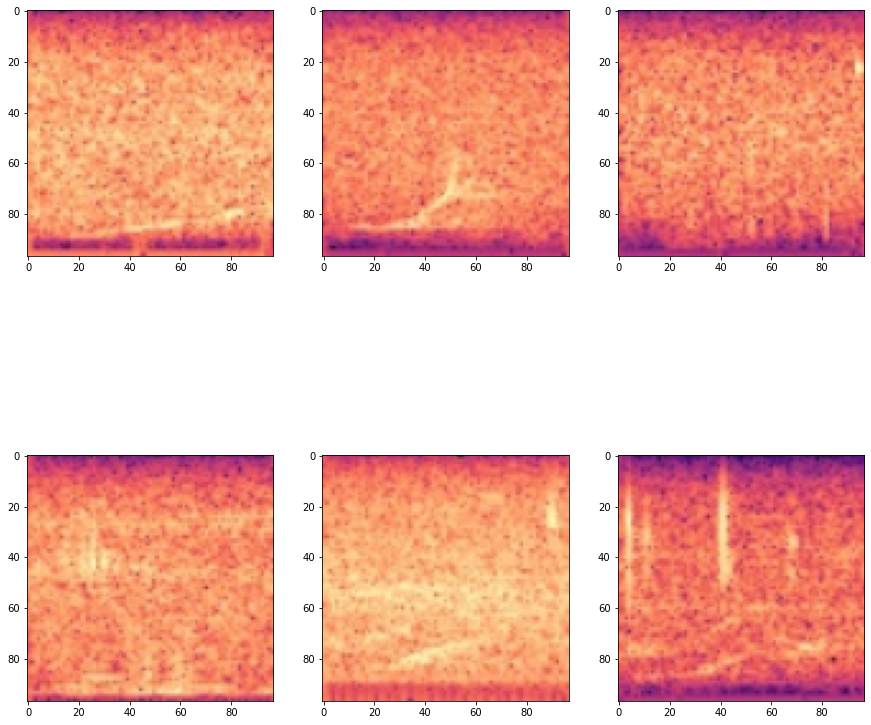

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15,15))
for images, labels in cb_validation.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

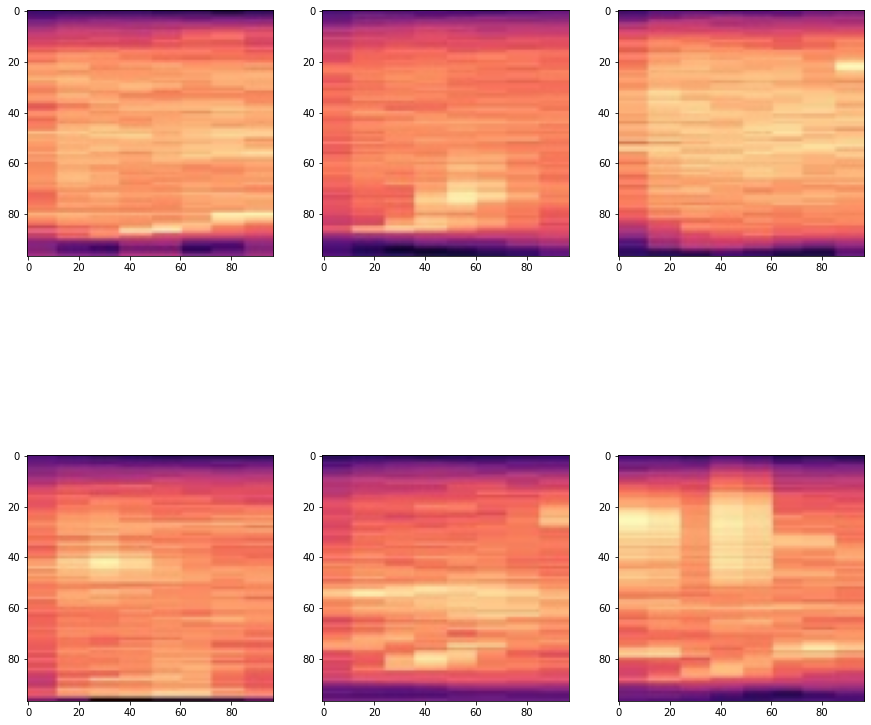

In [7]:
fig, axes = plt.subplots(2,3, figsize=(15,15))
for images, labels in s_validation.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

In [13]:
#checkpoint = ModelCheckpoint('transfer_vgg19_default_learn_rate.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# Experiment 1: Different spectrograms Resnet50

In [16]:
# Early stopping 

model = None
keras.backend.clear_session()


filename = 'resnet-cb.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)


predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)



history = model.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 5945s 8s/step - loss: 0.4990 - tp: 4446.0000 - fp: 4439.0000 - tn: 13933.0000 - fn: 1182.0000 - accuracy: 0.7658 - precision: 0.5004 - recall: 0.7900 - auc: 0.8482 - prc: 0.5892 - val_loss: 0.3495 - val_tp: 1208.0000 - val_fp: 788.0000 - val_tn: 3813.0000 - val_fn: 191.0000 - val_accuracy: 0.8368 - val_precision: 0.6052 - val_recall: 0.8635 - val_auc: 0.9223 - val_prc: 0.7733

Epoch 00001: val_accuracy improved from -inf to 0.83683, saving model to resnet-cb.h5
Epoch 2/10
750/750 [==============================] - 17692s 24s/step - loss: 0.3780 - tp: 4797.0000 - fp: 3594.0000 - tn: 14778.0000 - fn: 831.0000 - accuracy: 0.8156 - precision: 0.5717 - recall: 0.8523 - auc: 0.9080 - prc: 0.7353 - val_loss: 0.3203 - val_tp: 1236.0000 - val_fp: 746.0000 - val_tn: 3855.0000 - val_fn: 163.0000 -

In [18]:
# Early stopping 
model = None
keras.backend.clear_session()

filename = 'resnet-s.h5'
s_training, s_validation  = import_data(1)
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(.5)(x)


predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)



history = model.fit(s_training, epochs=10,validation_data=s_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/10
750/750 [==============================] - 442s 585ms/step - loss: 0.5047 - tp: 4468.0000 - fp: 4529.0000 - tn: 13843.0000 - fn: 1160.0000 - accuracy: 0.7630 - precision: 0.4966 - recall: 0.7939 - auc: 0.8439 - prc: 0.5686 - val_loss: 0.3539 - val_tp: 1242.0000 - val_fp: 885.0000 - val_tn: 3716.0000 - val_fn: 157.0000 - val_accuracy: 0.8263 - val_precision: 0.5839 - val_recall: 0.8878 - val_auc: 0.9235 - val_prc: 0.7806

Epoch 00001: val_accuracy improved from -inf to 0.82633, saving model to resnet-s.h5
Epoch 2/10
750/750 [==============================] - 444s 593ms/step - loss: 0.3722 - tp: 4878.0000 - fp: 3567.0000 - tn: 14805.0000 - fn: 750.0000 - accuracy: 0.8201 - precision: 0.5776 - recall: 0.8667 - auc: 0.9108 - prc: 0.7386 - val_loss: 0.3211 - val_tp: 1251.0000 - val_fp: 782.0000 - val_tn: 3819.0000 - val_fn: 148.0000 

{'loss': [0.504734992980957,
  0.37217530608177185,
  0.34007710218429565,
  0.31348246335983276,
  0.3000633120536804,
  0.2905295491218567],
 'tp': [4468.0, 4878.0, 4974.0, 5043.0, 5091.0, 5132.0],
 'fp': [4529.0, 3567.0, 3408.0, 3160.0, 3000.0, 2872.0],
 'tn': [13843.0, 14805.0, 14964.0, 15212.0, 15372.0, 15500.0],
 'fn': [1160.0, 750.0, 654.0, 585.0, 537.0, 496.0],
 'accuracy': [0.7629583477973938,
  0.8201249837875366,
  0.8307499885559082,
  0.84395831823349,
  0.8526250123977661,
  0.859666645526886],
 'precision': [0.49660998582839966,
  0.5776199102401733,
  0.5934144854545593,
  0.6147750616073608,
  0.6292176246643066,
  0.6411793828010559],
 'recall': [0.7938876748085022,
  0.8667377233505249,
  0.8837953209877014,
  0.8960554599761963,
  0.9045842289924622,
  0.9118692278862],
 'auc': [0.8439016342163086,
  0.910808265209198,
  0.9260088205337524,
  0.9363169074058533,
  0.9421067237854004,
  0.9458031058311462],
 'prc': [0.56856769323349,
  0.7386230826377869,
  0.7821611